Evaluating on alternative worlds

In [106]:
from swdata import (AsymScene, Scene, SWorld, TrainEx, load_components,
                    make_from_components)
import swdata
import numpy as np
%matplotlib inline


In [2]:
from rnn_syn import CONFIGS, build_end2end_model, RNN_CELLS

In [81]:
train_cf = CONFIGS['shape_color_generalization_3']['train']

In [4]:
import tensorflow as tf

In [5]:
tfs, tls, tfl, tll, t_msg, t_pred, t_loss, convs, convl = build_end2end_model(
                5,
                net_arch=(256, 64, 1024),
                discrete=False,
                rnncell=RNN_CELLS['gru'],
                asym=True)

In [6]:
session = tf.Session()

In [7]:
saver = tf.train.Saver()
saver.restore(session, 'saves/gen_521_1500.ckpt')

INFO:tensorflow:Restoring parameters from saves/gen_521_1500.ckpt


In [84]:
train_cf

['1000-square-blue-square-red',
 '1000-square-green-square-red',
 '1000-square-red-triangle-blue',
 '1000-square-red-triangle-green',
 '1000-circle-red-square-red',
 '1000-circle-blue-square-red',
 '1000-circle-green-square-red',
 '1000-square-blue-square-green',
 '1000-square-blue-triangle-blue',
 '1000-square-blue-triangle-green',
 '1000-circle-red-square-blue',
 '1000-circle-blue-square-blue',
 '1000-circle-green-square-blue',
 '1000-square-green-triangle-blue',
 '1000-square-green-triangle-green',
 '1000-circle-red-square-green',
 '1000-circle-blue-square-green',
 '1000-circle-green-square-green',
 '1000-triangle-blue-triangle-green',
 '1000-circle-red-triangle-blue',
 '1000-circle-blue-triangle-blue',
 '1000-circle-green-triangle-blue',
 '1000-circle-red-triangle-green',
 '1000-circle-blue-triangle-green',
 '1000-circle-green-triangle-green',
 '1000-circle-blue-circle-red',
 '1000-circle-green-circle-red',
 '1000-circle-blue-circle-green']

In [92]:
configs, components_dict = load_components(train_cf)

Load components: 100%|██████████| 28/28 [00:21<00:00,  1.28it/s]


In [103]:
other_accs = []
other_accs_rev = []
cf_txt = []

for config in configs:
    print(config)
    # It doesn't know common colors (yet)
    if config[0][1] == config[1][1]:
        print("same color ,continuing")
        continue
    cfs = [config]
    
    batch, batch_metadata = zip(*make_from_components(128, cfs, components_dict, False,
                     {'max_images': 5, 'min_targets': 2, 'min_distractors': 1},
                    weighted=False))
    rel1, rel1_md = zip(*(t for t in zip(batch, batch_metadata) if t[1]['relation_dir'] == 1))
    rel0, rel0_md = zip(*(t for t in zip(batch, batch_metadata) if
                          t[1]['relation_dir'] == -1 and t[1]['n_targets']))
    
    bse, bsl, batch_envs, batch_labels = \
        swdata.prepare_end2end(rel1, 5, asym=True)
        
    # Get target message
    tgt_msg, tgt_pred = session.run(
        [t_msg, t_pred], {
            tfs: np.array([bse[0]]),
            tls: np.array([bsl[0]]),
            tfl: np.array([batch_envs[0]]),
    })
    if not np.all((tgt_pred > 0) == np.array([batch_labels[0]]), axis=1):
        print("tgt not correct, continuing")
        continue
        
    # Repeat the message for the rest of the batch
    tgt_rep = np.vstack(tgt_msg for _ in range(batch_envs[1:].shape[0]))

    other_pred = session.run(
        t_pred, {
        t_msg: tgt_rep,
        tfl: batch_envs[1:]
    })
    acc = np.all((other_pred > 0) == batch_labels[1:], axis=1).mean()
    print("Like:", acc)
    other_accs.append(acc)

    # Reverse roles

    print(batch_envs.shape)

    bse, bsl, batch_envs, batch_labels = \
        swdata.prepare_end2end(rel0, 5, asym=True)
    
    tgt_rep = np.vstack(tgt_msg for _ in range(batch_envs[1:].shape[0]))
    
    rev_pred = session.run(
        t_pred, {
        t_msg: tgt_rep,
        tfl: batch_envs[1:]
    })
    acc_rev = np.all((rev_pred < 0) == batch_labels[1:], axis=1).mean()

    print("Opp:", acc_rev)
    other_accs_rev.append(acc_rev)
    cf_txt.append(str(config))

(('square', 'blue'), ('square', 'red'), 'x-rel')
tgt not correct, continuing
(('square', 'blue'), ('square', 'red'), 'y-rel')
Like: 0.9047619047619048
(64, 5, 64, 64, 3)
Opp: 0.5079365079365079
(('square', 'green'), ('square', 'red'), 'x-rel')
Like: 0.9333333333333333
(61, 5, 64, 64, 3)
Opp: 0.5151515151515151
(('square', 'green'), ('square', 'red'), 'y-rel')
Like: 0.9264705882352942
(69, 5, 64, 64, 3)
Opp: 0.5344827586206896
(('square', 'red'), ('triangle', 'blue'), 'x-rel')
Like: 0.8382352941176471
(69, 5, 64, 64, 3)
Opp: 0.6896551724137931
(('square', 'red'), ('triangle', 'blue'), 'y-rel')
Like: 0.8266666666666667
(76, 5, 64, 64, 3)
Opp: 0.5490196078431373
(('square', 'red'), ('triangle', 'green'), 'x-rel')
Like: 0.9661016949152542
(60, 5, 64, 64, 3)
Opp: 0.5671641791044776
(('square', 'red'), ('triangle', 'green'), 'y-rel')
Like: 0.8571428571428571
(71, 5, 64, 64, 3)
Opp: 0.5892857142857143
(('circle', 'red'), ('square', 'red'), 'x-rel')
same color ,continuing
(('circle', 'red'), (

In [102]:
import pandas as pd
import seaborn as sns

In [110]:
accs = pd.DataFrame({
    'acc': other_accs + other_accs_rev,
    'type': ['like' for _ in range(len(other_accs))] + ['opp' for _ in range(len(other_accs_rev))],
    'config': cf_txt * 2
})

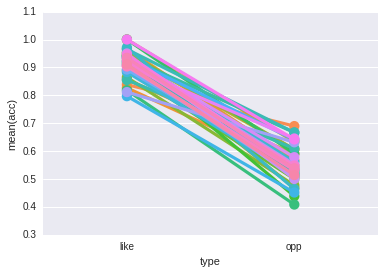

In [115]:
ax = sns.pointplot(x = 'type', y = 'acc', hue='config', data = accs)

ax.legend_.remove()

1. Worth doing continuous? (we care for e.g. encoder-decoder, also translating neuralese)
2. How to generalize to a statement about learning vs. just performance on this game?

3. Idea of "learning shapeworld captions", since in shapeworld you can generate
4. More distractors